# CHAOS - Combined (CT-MR) Healthy Abdominal Organ Segmentation Challenge Data

This dataset contains both computed tomography (CT) and magnetic resonance imaging (MRI) scans of healthy abdominal organs. The primary objective of the CHAOS Challenge is to advance the field of medical image segmentation by encouraging the development and evaluation of algorithms for accurately segmenting abdominal organs, including the liver, spleen, and kidneys.

- Website: https://chaos.grand-challenge.org/

- Dataset: https://zenodo.org/records/3431873#.ZSKsluxBy3I

- Paper: https://www.sciencedirect.com/science/article/pii/S1361841520303145?via%3Dihub

**Citation:**
>Kavur, A. E., Selver, M. A., Dicle, O., Barış, M., & Gezer, N. S. (2019, April).
>
> *CHAOS - Combined (CT-MR) Healthy Abdominal Organ Segmentation Challenge Data* (Version v1.03) [Data set]
>
> Zenodo. https://doi.org/10.5281/zenodo.3362844

### Connect to Drive
**(optional for Google Colab users)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Biomedical CV/

Mounted at /content/drive/
/content/drive/My Drive/Biomedical CV


### Download and unzip the CHAOS Challenge dataset
**(optional)**

In [ ]:
# Download and unzip the Train CHAOS Challenge dataset
download = False
if download:
  !curl -L -o CHAOS_Train_Sets.zip https://zenodo.org/records/3431873/files/CHAOS_Train_Sets.zip?download=1
  !unzip CHAOS_Train_Sets.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: Train_Sets/CT/28/Ground/liver_GT_059.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_060.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_061.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_062.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_063.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_064.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_065.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_066.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_067.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_068.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_069.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_070.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_071.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_072.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_073.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_074.png  
  inflating: Train_Sets/CT/28/Ground/liver_GT_075.png 

### Import Libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.8 MB/s eta 0:00:00


In [ ]:
# Import other libraries
import pydicom
import cv2
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset extraction functions

In [ ]:
def delete_ds_store_files(root_dir):
  '''
  Removes all MAC .DS_Store files from the CHAOS dataset
  '''
  for root, dirs, files in os.walk(root_dir):
    for file in files:
      if file == '.DS_Store':
        file_path = os.path.join(root, file)
        os.remove(file_path)
        print(f'Deleted: {file_path}')

In [ ]:
def get_files_dictionary(root_path, target_dir, file_ext):
  '''
  Creates and return a dictionary in the form {prodecure: patients: files: [file paths]}
  '''
  dict_paths = {}
  for path, _, files in sorted(os.walk(root_path)):
    if len(files) > 0 and files[0].endswith(file_ext):
      # Delete root path
      short_path = re.sub(root_path, '', path)
      # Delete patient id and DICOM_anon/Ground folders from path
      procedure = re.sub(target_dir+'|\/\d+', '', short_path)
      # Get the name of the procedure
      procedure = re.split('/', procedure)
      procedure_name = '_'.join([x for x in procedure if x != ''])

      # Add to dictionary the procedure, the patient id and file paths of .dcm/.jpg files
      patient_id = re.findall('\/\d+', short_path)[0][1:]
      if procedure_name not in list(dict_paths.keys()):
       dict_paths[procedure_name] = {}
      if patient_id not in list(dict_paths[procedure_name].keys()):
       dict_paths[procedure_name][patient_id] = {}
      dict_paths[procedure_name][patient_id]['files'] = [os.path.join(short_path, file) for file in sorted(files)]
  return dict_paths

In [ ]:
def join_raw_dcm_paths(dcm_paths, ground_paths):
  '''
  Creates and return a dictionary in the form {prodecure: patients: raw_files: [file paths], ground_files: [file paths]}
  '''
  dict_join = {}
  for procedure_name in list(dcm_paths.keys()):
    dict_join[procedure_name] = {}
    for patient_id in list(dcm_paths[procedure_name].keys()):
      ground_proc_name = procedure_name
      if 'MR_T1DUAL' in procedure_name:
        ground_proc_name = 'MR_T1DUAL'
      dict_join[procedure_name][patient_id] = {'raw_files' : dcm_paths[procedure_name][patient_id]['files'],
                                               'ground_files' : ground_paths[ground_proc_name][patient_id]['files']}
  return dict_join

In [ ]:
def extract_useful_dcm_data(dict_meta):
  '''
  Extracts useful information from DYCOM files and saves raw numpy arrays
  for posterior faster loading (.npy fastest method of loading in data)
  '''
  for proc in list(dict_meta.keys()):
    patients = dict_meta[proc]
    print('-'*40)
    print(f'Procedure {proc} - {len(list(patients.keys()))} patients')

    for id, files in patients.items():
      img_vol = []
      ground_img_vol = []
      # for every .png file of a patient in a medical procedure
      for png_filename in files['ground_files']:
        img_png = cv2.imread(os.path.join(chaos_path,png_filename), cv2.IMREAD_GRAYSCALE) # read png
        ground_img_vol.append(img_png) # append ground image to volume

      # for every .dcm file of a patient in a medical procedure
      for dcm_filename in files['raw_files']:
        img_dcm = pydicom.dcmread(os.path.join(chaos_path,dcm_filename)) # read dcm
        img = img_dcm.pixel_array
        img_vol.append(img) # append raw image to volume

      # Extract voxel characteristics
      z_space = None
      overlap = None
      try:
        z_space = img_dcm.SpacingBetweenSlices
        overlap = z_space - img_dcm.SliceThickness
      except:
        pass # Do nothing

      x_space = img_dcm.PixelSpacing [0]
      y_space = img_dcm.PixelSpacing [1]
      vox_dim = (x_space, y_space, z_space)

      # Extract aspect ratio and resolution
      aspect_ratio = None
      resolution = None
      try:
        aspect_ratio = img_dcm.PixelAspectRatio
        resolution = img_dcm.PixelBandwidth
      except:
        pass # Do nothing

      # Encode volume and save dataset as .npy
      raw_img_vol = np.array(img_vol, dtype='uint16')
      ground_img_vol = np.array(ground_img_vol, dtype='uint16')
      raw_data_vol = np.concatenate((np.expand_dims(raw_img_vol,axis=0), np.expand_dims(ground_img_vol,axis=0)), axis=0)
      np.save(os.path.join(raw_path, proc, f'{proc}_patient{id}'), raw_data_vol)

      # Append useful metadata to dictionary for future faster retrieval
      print(f'Patient {id} :\n\t{raw_img_vol.shape} volume (px) -- {vox_dim} voxel dim (mm) with {overlap} mm overlap')
      dict_meta[proc][id]['shape'] = raw_img_vol.shape
      dict_meta[proc][id]['vox_dim'] = vox_dim
      if aspect_ratio is not None and resolution is not None and overlap is not None:
        print(f'\t{aspect_ratio} aspect ratio -- {resolution} resolution Hz/px')
        dict_meta[proc][id]['aspect_ratio'] = aspect_ratio
        dict_meta[proc][id]['resolution'] = resolution
        dict_meta[proc][id]['overlap'] = overlap

  return dict_meta

### Metadata and raw dataset extraction

In [ ]:
# Useful file paths and extensions
chaos_path = '/content/drive/My Drive/Biomedical CV/Train_Sets/'
raw_path = '/content/drive/My Drive/Biomedical CV/CHAOS_RAW'

dicom_folder = 'DICOM_anon'
ground_folder = 'Ground'
dcm_ext = '.dcm'
png_ext = '.png'

In [ ]:
# Removes all MAC .DS_Store files from the CHAOS dataset
del_ds_store_files = False
if del_ds_store_files:
  delete_ds_store_files(chaos_path)

In [ ]:
# Loads a metadata dictionary in the form {prodecure: patients: raw_files: [file paths.dcm], ground_files: [file paths.png]}
dcm_paths = get_files_dictionary(chaos_path, dicom_folder, dcm_ext)
ground_paths = get_files_dictionary(chaos_path, ground_folder, png_ext)
dict_metadata = join_raw_dcm_paths(dcm_paths, ground_paths)

In [ ]:
# Example dycom file metadata
pydicom.dcmread(os.path.join(chaos_path,dcm_paths['MR_T1DUAL_InPhase']['1']['files'][20]))

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.107798602010020489928267355501518719051
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0014) Instance Creator UID                UI: 1.3.46.670589.11.20182.5
(

**NON-USEFUL** data for image pre-processing and segmentation
- File metadata
- Identifiers
- Data types
- Equipment
- Creation, adquisition and study times
- Patient's info. is null
- Study and sampling info.

**USEFUL** data for image pre-processing and segmentation
- Slice Thickness (in mm)
- Spacing Between (adjacent) Slices (in mm)
- Pixel Spacing (physical distance in the patient between the center of each pixel in mm)
- Pixel Aspect Ratio (ratio of the vertical size and horizontal size of the pixels)
- Pixel Bandwidth (hz/pixel resolution and quality of MRI)
- Rows (# rows in image)
- Columns (# columns in image)
- Pixel Array

**Helps resample images to match size while preserving real-world dimensions**

In [ ]:
# Extracts useful information from DYCOM files, saves raw numpy arrays and metadata dictionary
raw_numpy_saved = False
if not raw_numpy_saved:
  dict_metadata = extract_useful_dcm_data(dict_metadata)
  # Save metadata dictionary in a pickle file (for later faster retrieve)
  with open(os.path.join(raw_path, 'metadata.pkl'), 'wb') as f:
    pickle.dump(dict_metadata, f)

----------------------------------------
Procedure CT - 20 patients
Patient 1 :
	(96, 512, 512) volume (px) -- ('0.687671', '0.687671', None) voxel dim (mm) with None mm overlap
Patient 10 :
	(110, 512, 512) volume (px) -- ('0.693359375', '0.693359375', None) voxel dim (mm) with None mm overlap
Patient 14 :
	(95, 512, 512) volume (px) -- ('0.568359375', '0.568359375', None) voxel dim (mm) with None mm overlap
Patient 16 :
	(91, 512, 512) volume (px) -- ('0.791015625', '0.791015625', None) voxel dim (mm) with None mm overlap
Patient 18 :
	(111, 512, 512) volume (px) -- ('0.68359375', '0.68359375', None) voxel dim (mm) with None mm overlap
Patient 19 :
	(90, 512, 512) volume (px) -- ('0.666015625', '0.666015625', None) voxel dim (mm) with None mm overlap
Patient 2 :
	(81, 512, 512) volume (px) -- ('0.77734375', '0.77734375', None) voxel dim (mm) with None mm overlap
Patient 21 :
	(257, 512, 512) volume (px) -- ('0.78125', '0.78125', None) voxel dim (mm) with None mm overlap
Patient 22 :


### Dataset statistics

In [ ]:
# Create a DataFrame in order to summarize dataset metadata
metadata = []
for procedure in list(dict_metadata.keys()):
  patients = dict_metadata[procedure]
  for patient in patients.values():
    patient_metadata = []
    patient_metadata.append(procedure)
    patient_metadata.append(patient['shape'][0])
    patient_metadata.append(patient['shape'][1])
    patient_metadata.append(patient['shape'][2])
    patient_metadata.append(patient['vox_dim'][0])
    patient_metadata.append(patient['vox_dim'][1])
    patient_metadata.append(patient['vox_dim'][2])
    if 'aspect_ratio' in list(patient.keys()):
      patient_metadata.append(patient['overlap'])
      patient_metadata.append(patient['aspect_ratio'])
      patient_metadata.append(patient['resolution'])
    else:
      patient_metadata += [None, None, None]
    metadata.append(patient_metadata)

metadata = pd.DataFrame(metadata, columns=['Procedure', 'Axial_Slices', 'Spatial_x', 'Spatial_y', 'Voxel_x', 'Voxel_y', 'Voxel_z', 'Overlap', 'Aspect_Ratio', 'Resolution'])

In [ ]:
# Aggregate data to summarize most important aspects of the dataset
aggregations = {'Procedure' : 'count',
                'Axial_Slices' : [np.mean, np.sum, np.min, np.max],
                'Spatial_x' : [np.min, np.max],
                'Spatial_y' : [np.min, np.max],
                'Voxel_x' : [np.min, np.mean, np.max],
                'Voxel_y' : [np.min, np.mean, np.max],
                'Voxel_z' : [np.min, np.mean, np.max],
                'Overlap' : [np.min, np.max],
                'Resolution' : [np.min, np.max]
                }

metadata.groupby('Procedure').agg(aggregations)

Procedure Axial_Slices                Spatial_x       \
                       count         mean   sum min  max       min  max   
Procedure                                                                 
CT                        20       143.70  2874  81  266       512  512   
MR_T1DUAL_InPhase         20        32.35   647  26   50       256  288   
MR_T1DUAL_OutPhase        20        32.35   647  26   50       256  288   
MR_T2SPIR                 20        31.15   623  26   39       256  320   

                   Spatial_y        Voxel_x  ...   Voxel_y            \
                         min  max       min  ...       min      mean   
Procedure                                    ...                       
CT                       512  512  0.568359  ...  0.568359  0.698111   
MR_T1DUAL_InPhase        256  288  1.440972  ...  1.440972  1.648872   
MR_T1DUAL_OutPhase       256  288  1.440972  ...  1.440972  1.648872   
MR_T2SPIR                256  320  1.359375  ...  1.359375  1.551367   

                             Voxel_z             Overlap      Resolution  \
                         max     min   mean  max     min  max        min   
Procedure                                                                  
CT                  0.791016     NaN    NaN  NaN     NaN  NaN        NaN   
MR_T1DUAL_InPhase   2.031250     5.5  8.275  9.0     0.5  1.0      523.0   
MR_T1DUAL_OutPhase  2.031250     5.5  8.275  9.0     0.5  1.0      523.0   
MR_T2SPIR           1.816406     7.7  8.745  9.0     0.7  1.0      271.0   

                           
                      max  
Procedure                  
CT                    NaN  
MR_T1DUAL_InPhase   523.0  
MR_T1DUAL_OutPhase  523.0  
MR_T2SPIR           284.0  

[4 rows x 22 columns]

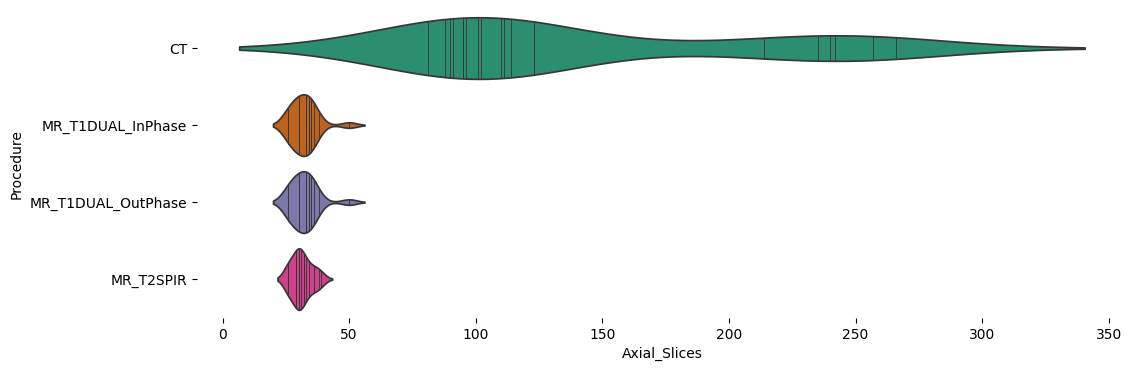

In [ ]:
# Axial slices distribution (violin plot) per procedure
plt.figure(figsize=(12, len(metadata['Procedure'].unique())))
sns.violinplot(metadata, x='Axial_Slices', y='Procedure', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

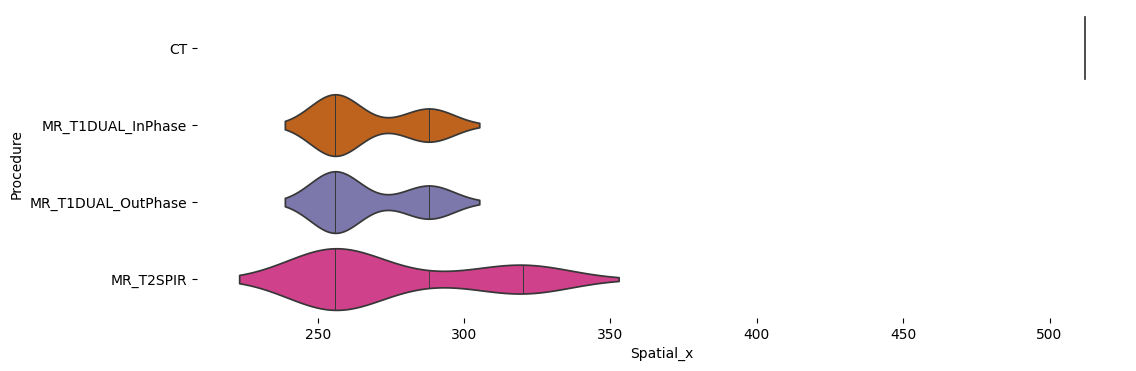

In [ ]:
# 2D spatial distribution (violin plot) per procedure
plt.figure(figsize=(12, len(metadata['Procedure'].unique())))
sns.violinplot(metadata, x='Spatial_x', y='Procedure', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

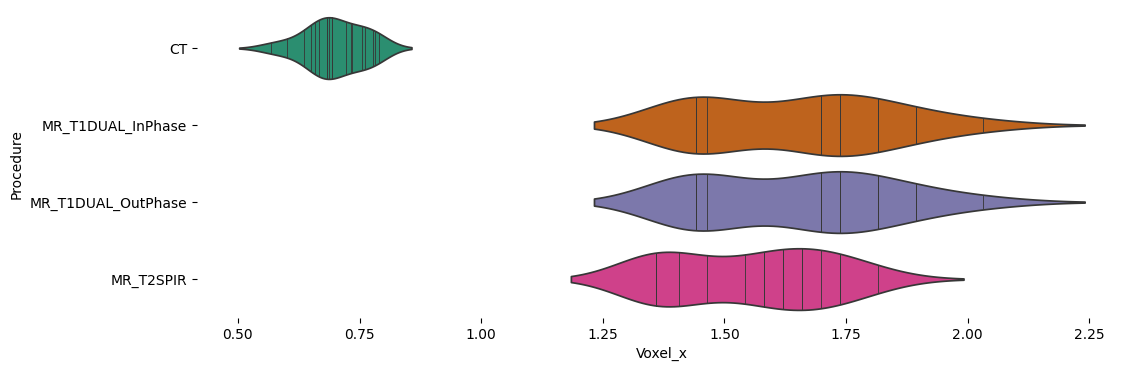

In [ ]:
# Voxel dimension distribution (violin plot) per procedure
plt.figure(figsize=(12, len(metadata['Procedure'].unique())))
sns.violinplot(metadata, x='Voxel_x', y='Procedure', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

**SUMMARY:**
**Train CHAOS Challenge dataset**

| Attribute | CT | MR |
|----------|----------|----------|
| **# patients**   | 20   | 20   |
| **# sets**   | 20   | 20x3   |
| **2D Spatial resolution**   | 512x512   | 256x256/288x288/320x320   |
| **# axial slices per patient [min-max]**   | [81-266]   | [26-50]   |
| **Average axial slices**   | 144  | 33x3   |
| **Total axial slices**   | 2874  | 647x3   |
| **Voxel X spacing (mm) [min-max]**   | [0.568-0.791]   | [1.441-2.031]  |
| **Voxel Y spacing (mm) [min-max]**   | [0.568-0.791]   | [1.441-2.031]  |
| **Voxel Z spacing (mm) [min-max]**   | ?   | [5.5-9.0]   |
| **Sampling overlap (mm) [min-max]**   | ?   | [0.5-1.0]   |
| **Resolution (hz/pixel)**   | ?   | 523 (T1) / [2.71-2.84] (T2)  |

**INSIGHTS:**
**Train CHAOS Challenge dataset**

According the statistics and distribution plots from each medical procedure, CT and MRI images present distinct statistical nature due to their inherent differences in data acquisition and resolution.

Comparing the two modalities, CT scans exhibit higher 2D spatial resolution 512x512 with a broader range of axial slices per patient (ranging from 81 to 266), but each pixel representing a smaller voxel in the real-world.

While MRI scans typically have a lower 2D spatial resolution 256x256 containing fewer slices (around 33 per patient), but each pixel representing a bigger voxel in the real-world.